# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new batch data.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for electricity prices, weather measures, and calendar. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar, electricity_prices  

# We go back into the notebooks folder
%cd pipeline

/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project
/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project/pipeline


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np
import tensorflow as tf

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> 📮 Retrieving model from Model Registry

In [4]:
# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the TensorFlow model from the Model Registry
model = mr.get_model(
    name="lstm_electricity_price_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Downloading the model to a local directory
model_dir = model.download()

# Loading the saved TensorFlow model
loaded_model = tf.saved_model.load(model_dir)

# Accessing the serving function of the loaded model
serving_function = loaded_model.signatures["serving_default"]

 The `"serving_default"` function from the loaded model's signatures. This serving function is designed for inference and is the entry point for making predictions with the model

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as batch data to make predictions.

In [6]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark(
    freq='H',
)

# Fetching the electricity prices
electricity_price_df = electricity_prices.electricity_prices(
    historical=True,
    area=["DK1"],
    start='2020-01-01'
)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [7]:
# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='timestamp', right_on='timestamp')

In [8]:
# Dropping and renaming columns
new_data.drop(columns=['datetime_y', 'hour_y', 'date_y'], inplace=True)
new_data.rename(columns={
    'date_x': 'date', 
    'datetime_x': 'datetime', 
    'hour_x': 'hour'}, inplace=True)

# Displaying the new data
new_data.tail()

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1717009200000,2024-05-29 19:00:00,2024-05-29,19,15.4,74.0,0.0,0.0,0.0,61.0,97.0,16.5,33.1,2,29,5,2024,1
116,1717012800000,2024-05-29 20:00:00,2024-05-29,20,15.3,75.0,0.0,0.0,0.0,61.0,98.0,16.5,33.8,2,29,5,2024,1
117,1717016400000,2024-05-29 21:00:00,2024-05-29,21,15.1,76.0,0.0,0.0,0.0,61.0,100.0,16.9,34.2,2,29,5,2024,1
118,1717020000000,2024-05-29 22:00:00,2024-05-29,22,14.6,80.0,1.0,1.0,0.0,61.0,100.0,17.4,36.0,2,29,5,2024,1
119,1717023600000,2024-05-29 23:00:00,2024-05-29,23,14.0,85.0,1.0,1.0,0.0,61.0,100.0,18.2,38.2,2,29,5,2024,1


In [10]:
# Making a copy of the new data and name it forecast_data
forecast_data = new_data.copy()

In [12]:
# Drop columns 'dk1_spotpricedkk_kwh', 'timestamp', 'datetime', and 'date' from the DataFrame 'forecast_data'
forecast_data.drop(columns=['timestamp', 'datetime', 'date'], inplace=True)

#### <span style="color:#2656a3;">👆 Feature Selection and Preprocessing</span>

In [14]:
# Import the MinMaxScaler from the sklearn library
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object and fit_transform the 'electricity_price_df' DataFrame
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit_transform(electricity_price_df[['dk1_spotpricedkk_kwh']])

array([[0.36153891],
       [0.36027605],
       [0.36012229],
       ...,
       [0.42455585],
       [0.41983653],
       [0.41231677]])

In [15]:
# Scaling the features
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(forecast_data)

# Imput the scaled features into a np array
data = np.array(features_scaled)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [16]:
# Prepare the data for LSTM model for the X_new_data
time_steps = 25 # 25 hours to get 00:00 hour in the sequence

# Create a list to store the sequences
X_new_data = []
for i in range(len(data) - time_steps + 1):
    X_new_data.append(data[i:(i + time_steps), :])
X_new_data = np.array(X_new_data)

## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures.

In [ ]:
# Using the serving function to make predictions
x = serving_function(tf.constant(X_new_data, dtype=tf.float32))

In [17]:
# Extracting and converting the predictions to a NumPy array
predictions = x[list(x.keys())[0]].numpy()

# Inverse transform the predictions to get the original scale
predictions = target_scaler.inverse_transform(predictions)

print(predictions)

[[ 0.14454302]
 [ 0.15722658]
 [ 0.15207553]
 [ 0.15182056]
 [ 0.1540328 ]
 [ 0.1489114 ]
 [ 0.1415045 ]
 [ 0.12263689]
 [ 0.08789778]
 [ 0.04718133]
 [ 0.00484487]
 [-0.02527148]
 [-0.04370442]
 [-0.01987359]
 [ 0.02745837]
 [ 0.04649053]
 [ 0.06529126]
 [ 0.09423126]
 [ 0.10909246]
 [ 0.08844844]
 [ 0.12010804]
 [ 0.08581055]
 [ 0.06061993]
 [ 0.07072984]
 [ 0.02373951]
 [ 0.00229624]
 [-0.0408386 ]
 [-0.00470625]
 [ 0.05443937]
 [ 0.09154366]
 [ 0.11637463]
 [ 0.11630835]
 [ 0.09700754]
 [ 0.08230044]
 [ 0.05099322]
 [ 0.00203224]
 [ 0.06623761]
 [-0.02599571]
 [ 0.03931651]
 [ 0.09762362]
 [ 0.21299234]
 [ 0.30868316]
 [ 0.32634562]
 [ 0.30445492]
 [ 0.32846802]
 [ 0.29335037]
 [ 0.24470077]
 [ 0.2086164 ]
 [ 0.20836811]
 [ 0.20120601]
 [ 0.18256025]
 [ 0.16808107]
 [ 0.16404589]
 [ 0.17070793]
 [ 0.17035206]
 [ 0.14734837]
 [ 0.10342244]
 [ 0.05903249]
 [ 0.01742578]
 [-0.01313249]
 [-0.02227511]
 [-0.01954331]
 [-0.01431202]
 [ 0.04058035]
 [ 0.04545113]
 [ 0.07255599]
 [ 0.09950

In [18]:
# Combine predictions with datetime index from new_data (adjust index as needed)
predictions_data = {
    'prediction': predictions.flatten(),  # Ensure predictions is 1D
    'time': new_data['datetime'][24:]  # Adjust index for look_back
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the new electricity price predictions
predictions_df

,prediction,time
24,0.144543,2024-05-26 00:00:00
25,0.157227,2024-05-26 01:00:00
26,0.152076,2024-05-26 02:00:00
27,0.151821,2024-05-26 03:00:00
28,0.154033,2024-05-26 04:00:00
...,...,...
115,0.035442,2024-05-29 19:00:00
116,0.026006,2024-05-29 20:00:00
117,0.018318,2024-05-29 21:00:00
118,-0.017095,2024-05-29 22:00:00


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization.

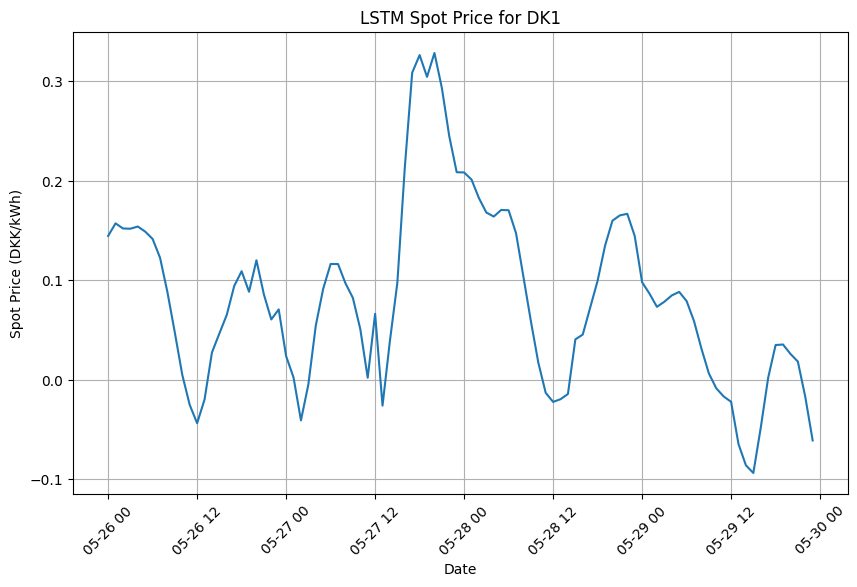

In [19]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)

# Adding labels and title
plt.title('LSTM Spot Price for DK1')
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK/kWh)')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [20]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T', 
    y='prediction:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f')
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our Python files for a Streamlit application ([link to Github repository](https://github.com/tobiasmj97/bds_m7_second-semester-project_streamlit)) </span>
